## Loading internet image

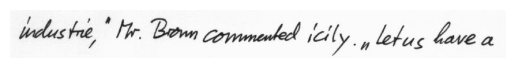

In [7]:
import requests
from PIL import Image  # Make sure to import the Image module
import matplotlib.pyplot as plt

url = "https://fki.tic.heia-fr.ch/static/img/a01-122-02.jpg" # An example images from 
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
image.convert("RGB")

# Plot the image
plt.axis('off')
plt.imshow(image)

## Loading local image

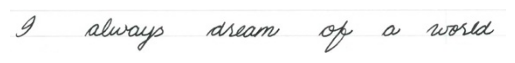

In [5]:
import os
from PIL import Image  # Make sure to import the Image module
import matplotlib.pyplot as plt

# import training image
def locate_child_file(child_folder, file_name):
    """This function assumes that the file is located in the same directory as the script.
    The file is packed within a folder. No nested folder is allowed."""
    script_directory = os.getcwd()
    # os.path.join() method in Python join one or more path components intelligently. It returns a string representing the path to a file.
    return os.path.join(script_directory, child_folder, file_name)

# We locate the image file by specifying the folder name and the file name, which our function will use.
file_name = 'handwritting_malala(crop)'
full_file_name = f"{file_name}.jpg"  # Removed .jpg here

# This returns the full path to the image file
train_img = locate_child_file(child_folder='Image', file_name=full_file_name) 

# This opens the image file
image = Image.open(train_img).convert("RGB")  # Convert the image to RGB mode

# Plot the image
plt.axis('off')
plt.imshow(image)
plt.show()  # Added this line to display the image


## TrOCR

In [4]:
!pip install transformers


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/fa/47/1a7daf04f40715fc1cdc6f1cc3200228a556d06c843e6ceb58883b745e1b/torch-2.1.0-cp310-cp310-win_amd64.whl.metadata
  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/59/af/426c2b90f5c4f8aba778746465af9e662680570e950e02379e91c6138285/torchvision-0.16.0-cp310-cp310-win_amd64.whl.metadata
  Obtaining dependency information for torchaudio from https://files.pythonhosted.org/packages/6b/ba/0e26883fd90f280452bed7edc7906ef9253255f395702751f65fa02afb5c/torchaudio-2.1.0-cp310-cp310-win_amd64.whl.metadata
     ---------------------------------------- 0.0/5.7 MB ? eta -:--:--
     -- ------------------------------------- 0.3/5.7 MB 7.0 MB/s eta 0:00:01
     ----- ---------------------------------- 0.8/5.7 MB 8.4 MB/s eta 0:00:01
     --------- ------------------------------ 1.4/5.7 MB 9.7 MB/s eta 0:00:01
     ------------- -------------------------- 2.0/5.7 MB 10.


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
!pip3 install torch torchvision torchaudio


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Pre-train the model

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\kinla\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\generation\utils.py:1421: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
c:\Users\kinla\AppData

Our train image:


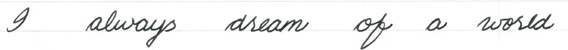

Recognition result:
I always dream of a world
Our test image:


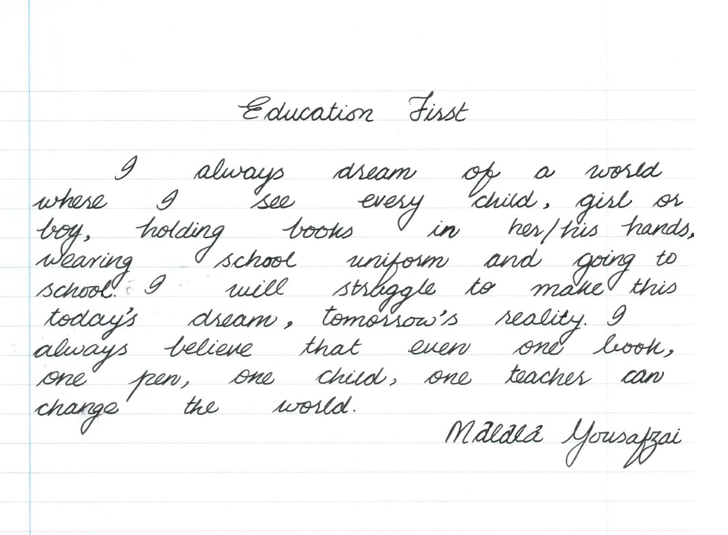

Recognition result:
spoken and the


In [13]:
from transformers import (
    TrOCRConfig,
    TrOCRProcessor,
    TrOCRForCausalLM,
    ViTConfig,
    ViTModel,
    VisionEncoderDecoderModel,
)
import requests
from PIL import Image

import IPython
import os

"""
Defining a set of functions to be used 
"""

# load image from the IAM dataset
def pixelize_image(img):
    image = Image.open(img).convert("RGB")
    pixel_values = processor(image, return_tensors="pt").pixel_values
    return pixel_values

# training
def training(processor, pixel_values, text):
    # decoder_start_token_id means the start token id for the decoder
    model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
    # pad_token_id means the token id for padding
    model.config.pad_token_id = processor.tokenizer.pad_token_id
    # vocab_size means the number of tokens in the vocabulary
    model.config.vocab_size = model.config.decoder.vocab_size

    # tojenizer means the tokenizer for the model. "pt" means the tokenizer for the PyTorch
    labels = processor.tokenizer(text, return_tensors="pt").input_ids
    outputs = model(pixel_values, labels=labels)
    loss = outputs.loss
    round(loss.item(), 2)

# inference training image
def print_result(img, text, message1, message2):
    print(message1)
    IPython.display.display(IPython.display.Image(img))
    print(message2)
    print(text)

"""
Configuring the model
"""
# TrOCR is a decoder model and should be used within a VisionEncoderDecoderModel
# init vision2text model with random weights
encoder = ViTModel(ViTConfig())
decoder = TrOCRForCausalLM(TrOCRConfig())
model = VisionEncoderDecoderModel(encoder=encoder, decoder=decoder)

# If you want to start from the pretrained model, load the checkpoint with `VisionEncoderDecoderModel`
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

"""
Training the model
"""

# import training image
script_directory = os.getcwd()
folder_path = os.path.join(script_directory, 'Image')
file_name = 'handwritting_malala(crop)'
train_img = os.path.join(folder_path, f'{file_name}.jpg')

pixel_value_train = pixelize_image(train_img)
text = "I always dream of a world"

training(processor, pixel_value_train, text)

generated_ids = model.generate(pixel_value_train)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

print_result(train_img, generated_text, "Our train image:", "Recognition result:")

"""
Using the model for inference
"""

# inference test image 
# import testing image
script_directory = os.getcwd()
folder_path = os.path.join(script_directory, 'Image')
file_name = 'handwritting_malala(full)'
test_img = os.path.join(folder_path, f'{file_name}.jpg')

pixel_values_test = pixelize_image(test_img)
generated_ids2 = model.generate(pixel_values_test)
generated_text2 = processor.batch_decode(generated_ids2, skip_special_tokens=True)[0]

print_result(test_img, generated_text2, "Our test image:", "Recognition result:")



In [5]:
!pip install sentencepiece

Defaulting to user installation because normal site-packages is not writeable


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/1 [00:00<?, ?it/s]

TAX


/home/kin/.local/lib/python3.10/site-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


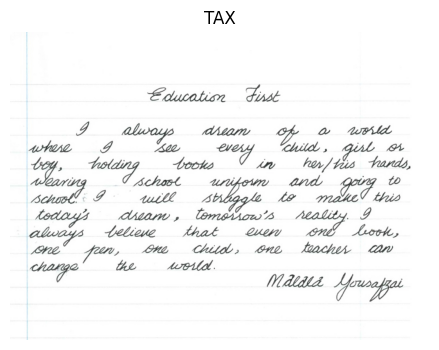

100%|██████████| 1/1 [00:00<00:00,  6.48it/s]


In [2]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
from tqdm.auto import tqdm
from urllib.request import urlretrieve
from zipfile import ZipFile
 
 
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import glob

	
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

def read_image(image_path):
    """
    :param image_path: String, path to the input image.
 
 
    Returns:
        image: PIL Image.
    """
    image = Image.open(image_path).convert('RGB')
    return image

def ocr(image, processor, model):
    """
    :param image: PIL Image.
    :param processor: Huggingface OCR processor.
    :param model: Huggingface OCR model.
 
 
    Returns:
        generated_text: the OCR'd text string.
    """
    # We can directly perform OCR on cropped images.
    pixel_values = processor(image, return_tensors='pt').pixel_values.to(device)
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

def eval_new_data(data_path=None, num_samples=4, model=None):
    image_paths = glob.glob(data_path)
    for i, image_path in tqdm(enumerate(image_paths), total=len(image_paths)):
        if i == num_samples:
            break
        image = read_image(image_path)
        text = ocr(image, processor, model)
        print(f"Recognized text is: {text}")
        plt.figure(figsize=(7, 4))
        plt.imshow(image)
        plt.title(text)
        plt.axis('off')
        plt.show()
        
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-small-printed')

model = VisionEncoderDecoderModel.from_pretrained(
    'microsoft/trocr-small-printed'
).to(device)

eval_new_data(
    data_path=os.path.join('Image', 'handwritting_malala(full).jpg'),
    num_samples=2,
    model=model
)